In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import BooleanType,DateType,FloatType,IntegerType,LongType

In [2]:
# Spark Session
spark = SparkSession.builder.appName('Fraud-Detector').getOrCreate()

22/01/07 18:16:32 WARN Utils: Your hostname, francesc-Inspiron-5570 resolves to a loopback address: 127.0.1.1; using 192.168.1.141 instead (on interface wlp3s0)
22/01/07 18:16:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/07 18:16:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Read datasets
df_train = spark.read.csv('data/clean_fraudTrain.csv', header=True)
df_test = spark.read.csv('data/clean_fraudTest.csv', header=True)

In [4]:
# Show Pretty Data
df_train.limit(5).toPandas()

,timestamp,credit_card_num,shop,category,amount,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,31
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,41
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.262,4154,Nature conservation officer,43.150704,-112.154481,0,57
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,M,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,52
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,33


In [5]:
# Cast Data
df_train.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- credit_card_num: string (nullable = true)
 |-- shop: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- age: string (nullable = true)



**We have to cast all the data because the csv, don't have meta-data that indicates the type.**

In [6]:
def cast_df(df):
    df = df.withColumn("credit_card_num",df.credit_card_num.cast(LongType()))
    df = df.withColumn("amount",df.amount.cast(FloatType()))
    df = df.withColumn("lat",df.lat.cast(FloatType()))
    df = df.withColumn("long",df.long.cast(FloatType()))
    df = df.withColumn("city_pop",df.city_pop.cast(IntegerType()))
    df = df.withColumn("merch_lat",df.merch_lat.cast(FloatType()))
    df = df.withColumn("merch_long",df.merch_long.cast(FloatType()))
    df = df.withColumn("is_fraud",df.is_fraud.cast(IntegerType()))
    df = df.withColumn("age",df.age.cast(IntegerType()))
    return df

In [7]:
# Cast
df_train = cast_df(df_train)
df_test = cast_df(df_test)

In [ ]:
# Drop
df_train = df_train.drop("timestamp")
df_test = df_test.drop("timestamp")

In [8]:
# Encode Categorical Variables
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline

cat_col = ['shop','category','gender','job']

list_string_indexer = [StringIndexer(inputCol= c, outputCol= c+"_indexed") for c in cat_col]
ppl = Pipeline(stages= list_string_indexer)

df_train_indexed = ppl.fit(df_train).transform(df_train).drop(*cat_col)
df_test_indexed = ppl.fit(df_test).transform(df_test).drop(*cat_col)

**We have to encode string variables to int, because the algorithm/s that we will use don't support strings.** 

In [9]:
df_train_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed
0,2703186189652095,4.970000,36.078800,-81.178101,3495,36.011292,-82.048317,0,31,571.0,11.0,0.0,141.0
1,630423337322,107.230003,48.887798,-118.210503,149,49.159046,-118.186462,0,41,81.0,1.0,0.0,61.0
2,38859492057661,220.110001,42.180801,-112.262001,4154,43.150703,-112.154480,0,57,319.0,6.0,1.0,457.0
3,3534093764340240,45.000000,46.230598,-112.113800,1939,47.034332,-112.561073,0,52,40.0,0.0,1.0,232.0
4,375534208663984,41.959999,38.420700,-79.462898,99,38.674999,-78.632462,0,33,519.0,10.0,1.0,297.0


In [10]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['credit_card_num', 'amount', 'lat', 'long','city_pop','merch_lat','merch_long','age']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

df_train_indexed = assembler.transform(df_train_indexed)
df_test_indexed = assembler.transform(df_test_indexed)

In [11]:
df_test_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965..."
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320..."
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67..."
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569..."
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252..."


In [12]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="features", numTrees=5)
model = rf.fit(df_train_indexed)

In [13]:
# Make Predictions
predictions = model.transform(df_test_indexed)

In [14]:
predictions.limit(10).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features,rawPrediction,probability,prediction
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965...","[4.987206882250664, 0.012793117749335562]","[0.9974413764501329, 0.0025586235498671122]",0.0
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320...","[4.985202539407038, 0.014797460592961477]","[0.9970405078814076, 0.0029594921185922955]",0.0
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67...","[4.981917463606961, 0.018082536393038827]","[0.9963834927213921, 0.0036165072786077655]",0.0
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569...","[4.984414894316284, 0.015585105683715558]","[0.9968829788632568, 0.003117021136743112]",0.0
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252...","[4.981917463606961, 0.018082536393038827]","[0.9963834927213921, 0.0036165072786077655]",0.0
5,30407675418785,19.549999,42.193901,-76.736099,520,41.747158,-77.584198,0,29,214.0,4.0,0.0,275.0,"[30407675418785.0, 19.549999237060547, 42.1939...","[4.985158093596729, 0.014841906403271217]","[0.9970316187193458, 0.0029683812806542433]",0.0
6,213180742685905,133.929993,40.507000,-123.974297,1139,41.499458,-124.888725,0,69,494.0,9.0,0.0,68.0,"[213180742685905.0, 133.92999267578125, 40.506...","[4.9819619094172705, 0.018038090582729087]","[0.9963923818834542, 0.003607618116545818]",0.0
7,3589289942931264,10.370000,43.755699,-97.593597,343,44.495499,-97.728455,0,48,379.0,7.0,0.0,154.0,"[3589289942931264.0, 10.369999885559082, 43.75...","[4.985202539407038, 0.014797460592961477]","[0.9970405078814076, 0.0029594921185922955]",0.0
8,3596357274378601,4.370000,41.000099,-78.235703,3688,41.546066,-78.120239,0,47,237.0,3.0,1.0,232.0,"[3596357274378601.0, 4.369999885559082, 41.000...","[4.984414894316284, 0.015585105683715558]","[0.9968829788632568, 0.003117021136743112]",0.0
9,3546897637165774,66.540001,31.659100,-96.809402,263,31.782919,-96.366188,0,64,422.0,8.0,0.0,23.0,"[3546897637165774.0, 66.54000091552734, 31.659...","[4.980725121517509, 0.01927487848249136]","[0.9961450243035017, 0.0038549756964982723]",0.0


In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9961347371603274
Test Error = 0.0038652628396725897


In [16]:
# Metrics
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','is_fraud']).withColumn('is_fraud', F.col('is_fraud').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','is_fraud'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))


In [17]:
# Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()

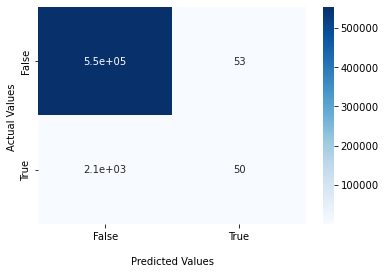

In [18]:
import seaborn as sns

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
# Decode Labels
list_index_string = [IndexToString(inputCol= c+"_indexed", outputCol=c ) for c in cat_col]
ppl = Pipeline(stages= list_index_string)

df_train_decoded = ppl.fit(df_train_indexed).transform(df_train_indexed).drop(*['shop_indexed','gender_indexed','job_indexed','features'])
df_test_decoded = ppl.fit(predictions).transform(predictions).drop(*['shop_indexed','gender_indexed','job_indexed','features','rawPrediction','probability'])

In [20]:
df_test_decoded.filter(df_test_decoded.is_fraud != df_test_decoded.prediction).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
1,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
2,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
3,4005676619255478,1077.689941,30.459000,-90.902702,71335,31.204973,-90.261597,1,26,5.0,0.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Herbalist
4,3560725013359375,842.650024,31.859900,-102.741302,23,31.315783,-102.736389,1,51,3.0,0.0,fraud_Hermann and Sons,shopping_pos,F,Cytogeneticist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,2657850734909997,978.340027,42.374901,-83.108704,673342,42.682968,-82.207062,0,74,5.0,1.0,fraud_Cormier LLC,shopping_net,M,Trading standards officer
2144,3536918668124647,807.159973,37.330399,-121.791298,973849,36.632526,-121.588928,0,66,5.0,1.0,"fraud_Langworth, Boehm and Gulgowski",shopping_net,F,Science writer
2145,3577794103155425,791.929993,47.706799,-97.209198,733,46.929577,-96.944359,0,26,5.0,1.0,"fraud_Altenwerth, Cartwright and Koss",shopping_net,F,Visual merchandiser
2146,4997733566924489,850.690002,44.991299,-92.948700,753116,45.049583,-93.779434,0,49,5.0,1.0,fraud_Fisher-Schowalter,shopping_net,F,Fisheries officer


In [22]:
df_test_decoded.filter(df_test_decoded.is_fraud == 1).filter(df_test_decoded.prediction == 0).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
1,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
2,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
3,4005676619255478,1077.689941,30.459000,-90.902702,71335,31.204973,-90.261597,1,26,5.0,0.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Herbalist
4,3560725013359375,842.650024,31.859900,-102.741302,23,31.315783,-102.736389,1,51,3.0,0.0,fraud_Hermann and Sons,shopping_pos,F,Cytogeneticist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,2242176657877538,1041.510010,34.632301,-89.885498,14462,34.573471,-89.911011,1,62,3.0,0.0,"fraud_Willms, Kris and Bergnaum",shopping_pos,M,Database administrator
2091,2242176657877538,868.090027,34.632301,-89.885498,14462,34.091228,-90.390610,1,62,3.0,0.0,fraud_Kuhn LLC,shopping_pos,M,Database administrator
2092,2242176657877538,1039.420044,34.632301,-89.885498,14462,34.628433,-90.284782,1,62,5.0,0.0,"fraud_Mosciski, Ziemann and Farrell",shopping_net,M,Database administrator
2093,2242176657877538,289.269989,34.632301,-89.885498,14462,34.746063,-90.401093,1,62,1.0,0.0,fraud_Bauch-Raynor,grocery_pos,M,Database administrator


In [23]:
df_test_decoded.filter(df_test_decoded.is_fraud == 0).filter(df_test_decoded.prediction == 1).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,4997733566924489,1270.099976,44.991299,-92.948700,753116,44.161583,-92.376610,0,49,3.0,1.0,fraud_Kihn Inc,shopping_pos,F,Fisheries officer
1,6535328428560433,1010.229980,45.063202,-93.381104,1022298,45.432636,-93.716972,0,53,10.0,1.0,fraud_Thiel PLC,misc_pos,F,Analytical chemist
2,4997733566924489,1386.560059,44.991299,-92.948700,753116,45.841499,-93.887665,0,49,3.0,1.0,fraud_Pagac LLC,shopping_pos,F,Fisheries officer
3,3500969075198072,934.859985,47.227100,-117.081902,895,46.292583,-117.068588,0,21,5.0,1.0,fraud_Jast Ltd,shopping_net,M,Clothing/textile technologist
4,3541554378551366,957.289978,37.046200,-76.409599,136895,36.623238,-76.980507,0,81,3.0,1.0,"fraud_Bernhard, Grant and Langworth",shopping_pos,F,Accounting technician
5,4745996322265,1178.109985,41.480202,-86.691902,1423,41.726082,-87.666710,0,22,5.0,1.0,"fraud_Labadie, Treutel and Bode",shopping_net,F,"Psychologist, forensic"
6,6011305591981276,3348.290039,34.620499,-86.551003,190178,35.159916,-87.208145,0,61,13.0,1.0,fraud_Jerde-Hermann,travel,M,"Engineer, automotive"
7,571365235126,1421.630005,44.599499,-86.214104,372,44.891010,-86.016319,0,25,5.0,1.0,"fraud_Reichert, Huels and Hoppe",shopping_net,F,"Exhibitions officer, museum/gallery"
8,3583093681934489,974.450012,38.190102,-85.751900,736284,38.080795,-85.252464,0,59,5.0,1.0,fraud_Lemke-Gutmann,shopping_net,F,"Education officer, museum"
9,6011305591981276,996.150024,34.620499,-86.551003,190178,35.117264,-86.453316,0,61,11.0,1.0,fraud_Schmitt Ltd,misc_net,M,"Engineer, automotive"
